# Evaluación Final MOD3 - Mar Pastor
---

### Ejercicio EDA y Vizualización de datos

En este ejercicio usaremos datos que consisten en dos BBDD de tipo CSV que contienen datos que describen el comportamiento de los clientes dentro de un programa de lealtad de una aerolínea.

Exploraremos los archivos:

- `Customer Flight Activity.csv` que contiene información sobre la actividad de vuelo de los clientes.

- `Customer Loyalty History.csv` que proporciona un perfil detallado de los clientes y detalles sobre su membresía en el programa de lealtad.

---

In [432]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
#import scipy.stats as stats
import scipy.stats as st
import scipy.stats as stats
from scipy.stats import shapiro, poisson, chisquare, expon, kstest

# Configuración
# ------------------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # ocultar alerstas de pandas

In [433]:
# cargar los DataFrame desde los archivos CSV, de la carpeta 'data':

df_flight = pd.read_csv('../data/Customer Flight Activity.csv')
df_loyalty = pd.read_csv('../data/Customer Loyalty History.csv')

### NOTA: Se decide trabajar cada DataFrame de forma individual para la exploración y limpieza de los datos, para luego realizar la unión de ambos en una DataFrame completo.

---

## I. Trabajamos con el DataFrame de información sobre la actividad de vuelo de los clientes.

#### DataFrame: `df_flight`

---

In [434]:
# 1. Explorar la visión general del DataFrame:

display(df_flight.head(2)) # visualizar los primeros datos del DataFrame
print('***' * 40)
display(df_flight.tail(2)) # visualizar los últimos datos del DataFrame
print('***' * 40)
display(df_flight.sample(2)) # visualizar datos aleatorios del DataFrame

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,2017,1,3,0,3,1521,152.0,0,0
1,100102,2017,1,10,4,14,2030,203.0,0,0


************************************************************************************************************************


,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
405622,999982,2018,12,0,0,0,0,0.0,0,0
405623,999986,2018,12,0,0,0,0,0.0,0,0


************************************************************************************************************************


,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
387786,507189,2018,9,7,4,11,891,89.0,518,42
89456,365642,2017,6,18,0,18,4932,493.0,0,0


In [435]:
# explorar el número de filas y columnas del DataFrame usando el método '.shape' 
# indicando el índice del array (0 para filas y 1 para columnas):
 
print(f"El número de filas es {df_flight.shape[0]}, el número de columnas es {df_flight.shape[1]}")

El número de filas es 405624, el número de columnas es 10


In [436]:
# explorar los nombres de las columnas usando el método '.columns':

df_flight.columns

# obervación: vemos que hay un patrón consistente en el nombre de las columnas (todos en inglés) 
# pero se decide modificar todos los nombres a minúsculas y las palabras separadas por '_' en lugar de espacios
# pensando en luego hacer una inserción de datos usando Python + SQL

Index(['Loyalty Number', 'Year', 'Month', 'Flights Booked',
       'Flights with Companions', 'Total Flights', 'Distance',
       'Points Accumulated', 'Points Redeemed', 'Dollar Cost Points Redeemed'],
      dtype='object')

In [437]:
# crear un nuevo diccionario para reemplazar el nombre de las columnas con nlas nuevas condiciones
# usando una 'list comprehension para iteractuar por cada nombre de columna en el DataFrame

nuevas_columnas = {col: col.lower().replace(' ','_') for col in df_flight.columns}
nuevas_columnas # imprime el diccionario con el nombre original y el nombre con nomenclatura unificada

{'Loyalty Number': 'loyalty_number',
 'Year': 'year',
 'Month': 'month',
 'Flights Booked': 'flights_booked',
 'Flights with Companions': 'flights_with_companions',
 'Total Flights': 'total_flights',
 'Distance': 'distance',
 'Points Accumulated': 'points_accumulated',
 'Points Redeemed': 'points_redeemed',
 'Dollar Cost Points Redeemed': 'dollar_cost_points_redeemed'}

In [438]:
# aplicar el cambio de nombre de columnas usando el diccionario creado usando la función 'rename()'

df_flight.rename(columns = nuevas_columnas, inplace=True)
df_flight.columns # comprobar los cambios realizados

Index(['loyalty_number', 'year', 'month', 'flights_booked',
       'flights_with_companions', 'total_flights', 'distance',
       'points_accumulated', 'points_redeemed', 'dollar_cost_points_redeemed'],
      dtype='object')

In [439]:
# 2. Explorar la información del DataFrame:

df_flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loyalty_number               405624 non-null  int64  
 1   year                         405624 non-null  int64  
 2   month                        405624 non-null  int64  
 3   flights_booked               405624 non-null  int64  
 4   flights_with_companions      405624 non-null  int64  
 5   total_flights                405624 non-null  int64  
 6   distance                     405624 non-null  int64  
 7   points_accumulated           405624 non-null  float64
 8   points_redeemed              405624 non-null  int64  
 9   dollar_cost_points_redeemed  405624 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 30.9 MB


### Primeras conclusiones basadas de la exploración de datos del DataFrame:

- No existen datos nulos, por lo que no haremos ninguna gestión de nulos en este DataFrame.

- Las columnas tienen nombres unificados con la nomenclatura general.

- La columna 'points_accumulated' tiene un tipo de dato 'float'. Podríamos unificar los datos y cambiarlo a 'entero/int'.

- Las columnas 'year' y 'month' las convertimos a 'object/str' para tratarlas como unas columna categórica en el análisis.

---

In [440]:
# convertir dato 'float' a 'int' en la columna 'points_accumulated'

df_flight['points_accumulated'] = df_flight['points_accumulated'].astype(int)
df_flight.info() # imprimimos la información del DataFrame para comprobar el cambio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   loyalty_number               405624 non-null  int64
 1   year                         405624 non-null  int64
 2   month                        405624 non-null  int64
 3   flights_booked               405624 non-null  int64
 4   flights_with_companions      405624 non-null  int64
 5   total_flights                405624 non-null  int64
 6   distance                     405624 non-null  int64
 7   points_accumulated           405624 non-null  int32
 8   points_redeemed              405624 non-null  int64
 9   dollar_cost_points_redeemed  405624 non-null  int64
dtypes: int32(1), int64(9)
memory usage: 29.4 MB


In [441]:
# convertir dato 'int' a 'object' en la columna 'year'

df_flight['year'] = df_flight['year'].astype('object')
df_flight.info() # imprimimos la información del DataFrame para comprobar el cambio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   loyalty_number               405624 non-null  int64 
 1   year                         405624 non-null  object
 2   month                        405624 non-null  int64 
 3   flights_booked               405624 non-null  int64 
 4   flights_with_companions      405624 non-null  int64 
 5   total_flights                405624 non-null  int64 
 6   distance                     405624 non-null  int64 
 7   points_accumulated           405624 non-null  int32 
 8   points_redeemed              405624 non-null  int64 
 9   dollar_cost_points_redeemed  405624 non-null  int64 
dtypes: int32(1), int64(8), object(1)
memory usage: 29.4+ MB


In [442]:
# convertir dato 'int' a 'str' que convierte a 'object' en la columna 'month'

df_flight['month'] = df_flight['month'].astype('str')
df_flight.info() # imprimimos la información del DataFrame para comprobar el cambio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   loyalty_number               405624 non-null  int64 
 1   year                         405624 non-null  object
 2   month                        405624 non-null  object
 3   flights_booked               405624 non-null  int64 
 4   flights_with_companions      405624 non-null  int64 
 5   total_flights                405624 non-null  int64 
 6   distance                     405624 non-null  int64 
 7   points_accumulated           405624 non-null  int32 
 8   points_redeemed              405624 non-null  int64 
 9   dollar_cost_points_redeemed  405624 non-null  int64 
dtypes: int32(1), int64(7), object(2)
memory usage: 29.4+ MB


In [443]:
df_flight.head(2)

# los meses están expresados en números. Se decide modificarlos a los nombres de los meses para mejorar la visualización del análisis

,loyalty_number,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
0,100018,2017,1,3,0,3,1521,152,0,0
1,100102,2017,1,10,4,14,2030,203,0,0


In [444]:
# convertir los números de los meses por los nombre de los meses para mejor comprensión
# usando una diccionario como máscara que asigna a cada numero un nombre de mes

mapa_mes = {'1': 'Enero', '2': 'Febrero', '3': 'Marzo', '4': 'Abril', '5': 'Mayo', '6': 'Junio', 
            '7': 'Julio', '8': 'Agosto', '9': 'Septiembre', '10': 'Octubre', '11': 'Noviembre', '12': 'Diciembre'}

df_flight['month'] = df_flight['month'].map(mapa_mes) # usamos 'map' porque ya verificamos que no tenemos valores nulos en esta columna
df_flight['month'].unique() # imprimimos los datos únicos en la columna para verificar los cambios

array(['Enero', 'Septiembre', 'Febrero', 'Marzo', 'Noviembre', 'Abril',
       'Mayo', 'Julio', 'Junio', 'Agosto', 'Octubre', 'Diciembre'],
      dtype=object)

In [445]:
# 3. Explorar los datos de las columnas categóricas usando la función 'describe()'

df_flight.describe(include='O').T

,count,unique,top,freq
year,405624,2,2017,202812
month,405624,12,Enero,33802


In [446]:
# exploramos los datos de las columnas numéricas usando la función 'describe()'

df_flight.describe().T

# concluímos que la media y la mediana no están cercanas en muchos de los datos de algunas columnas, 
# y en algunas columnas la dispersión de los datos es alta en algunos casos

,count,mean,std,min,25%,50%,75%,max
loyalty_number,405624.0,550037.873084,258935.286969,100018.0,326961.0,550834.0,772194.0,999986.0
flights_booked,405624.0,4.115052,5.225518,0.0,0.0,1.0,8.0,21.0
flights_with_companions,405624.0,1.031805,2.076869,0.0,0.0,0.0,1.0,11.0
total_flights,405624.0,5.146858,6.521227,0.0,0.0,1.0,10.0,32.0
distance,405624.0,1208.880059,1433.155320,0.0,0.0,488.0,2336.0,6293.0
points_accumulated,405624.0,123.667002,146.579083,0.0,0.0,50.0,239.0,676.0
points_redeemed,405624.0,30.696872,125.486049,0.0,0.0,0.0,0.0,876.0
dollar_cost_points_redeemed,405624.0,2.484503,10.150038,0.0,0.0,0.0,0.0,71.0


In [447]:
# 4. Explorar el DataFrame para detectar registros duplicados

df_flight.duplicated().sum() # usar las funciones 'duplicated()' y 'sum()'
# se registran 1864 entradas de datos duplicadas

1864

In [448]:
# crear una mascara que guarde los datos duplicados del DataFrame usando la función 'duplicated()'

mascara = df_flight.duplicated(keep=False) # mantenemos visible las entradas originales y las duplicadas
df_flight[mascara].sort_values('loyalty_number') # aplicamos la mascara para la columna de los id de los clientes, que deben ser únicos

# obervación: comprobamos que un mismo cliente se repite en diferentes meses, pero sin ningún otro dato registrado en el resto de columnas

,loyalty_number,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
41,101902,2017,Enero,0,0,0,0,0,0,0
33843,101902,2017,Marzo,0,0,0,0,0,0,0
16942,101902,2017,Febrero,0,0,0,0,0,0,0
185952,101902,2017,Diciembre,0,0,0,0,0,0,0
185953,101902,2017,Diciembre,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
354784,992168,2018,Septiembre,0,0,0,0,0,0,0
33665,992168,2017,Febrero,0,0,0,0,0,0,0
33664,992168,2017,Febrero,0,0,0,0,0,0,0
101269,992168,2017,Junio,0,0,0,0,0,0,0


In [449]:
# crear una nueva variable usando las mascara que contiene los duplicados de antes

mascara = df_flight.duplicated(keep=False)
duplicados = df_flight[mascara]

# agrupar usando la función 'groupby()' por 'loyalty_number' y contamos cuántas veces aparece cada uno para explorar a profundidad
# la función 'reset_index()' crea una nueva columna al que se le asigna un nombre para mejor visibilidad
conteo_por_cliente = duplicados.groupby('loyalty_number').size().reset_index(name='cantidad_duplicados') # crea un nueva columna

# ordenar los datos comenzando por los que tienen más duplicados usando la función 'sort_values()' en orden descendente
conteo_por_cliente = conteo_por_cliente.sort_values(by='cantidad_duplicados', ascending=False)
conteo_por_cliente # imprimir el DataFrame para verificar

,loyalty_number,cantidad_duplicados
94,678205,52
60,467894,48
64,488224,48
114,762990,48
110,741848,48
...,...,...
67,499874,2
104,713132,2
1,106001,2
70,512296,2


In [450]:
# Luego de visualizar todas las entradas duplicadas y agrupadas, se toma la decision de eliminar estos datos duplicados
# para que no afecten los análisis siguientes.

### NOTA 1: Se verificó que habían muchas entradas con valores '0' en varias columnas, lo que afectaba las visualizaciones de los datos.

Siguiendo este razonamiento, se decide explorar los datos duplicados primero y luego de verificar que son clientes repetidos múltiple veces y sin ningún registro en las demás columnas. Se decide eliminar estos registros para que no afecten los análisis siguientes.

### NOTA 2: Se le podría sugerir a la empresa que recoge los datos revisar el sistema de registro de clientes.

Se busca evitar que se generen diferentes entrada para un mismo cliente, o generar alguna alerta cuando se intente registrar un cliente que ya existe en la base de datos.

---

In [451]:
# eliminar los datos duplicados con la función 'drop_duplicates()'

df_flight.drop_duplicates(inplace=True)
df_flight.duplicated().sum() # imprimir para verificar que no tenemos duplicados en el DataFrame

0

In [452]:
# verificar el total de filas de DataFrame después de la eliminación

df_flight.info()

# observación: el DataFrame contenía originalmente 405.624 entradas. Al elimnar los duplicados las entradas total quedan en 403.760
# cálculo de verificación: 405.624 - 403.760 = 1.864 (cantidad total datos duplicados detectados anteriormente)

<class 'pandas.core.frame.DataFrame'>
Index: 403760 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   loyalty_number               403760 non-null  int64 
 1   year                         403760 non-null  object
 2   month                        403760 non-null  object
 3   flights_booked               403760 non-null  int64 
 4   flights_with_companions      403760 non-null  int64 
 5   total_flights                403760 non-null  int64 
 6   distance                     403760 non-null  int64 
 7   points_accumulated           403760 non-null  int32 
 8   points_redeemed              403760 non-null  int64 
 9   dollar_cost_points_redeemed  403760 non-null  int64 
dtypes: int32(1), int64(7), object(2)
memory usage: 32.3+ MB


In [453]:
# 5. Análisis de las variables categóricas, usando funciones de 'select_dtypes()' y 'value_count()' dentro de un bucle 'for'

for col in df_flight.select_dtypes(include='O').columns:
    print(f"Columna --> {col}")
    print(f"{df_flight[col].value_counts()}")
    print('***' * 25)

# observación: En el 2018 se realizaron mas vuelos
# Tenemos datos de los vuelos del 2018 y 2017
# El mes que mas se realizaron mas vuelos fue 'Noviembre'

Columna --> year
year
2018    202022
2017    201738
Name: count, dtype: int64
***************************************************************************
Columna --> month
month
Noviembre     33663
Octubre       33662
Diciembre     33662
Septiembre    33659
Agosto        33655
Julio         33648
Junio         33646
Abril         33640
Mayo          33640
Marzo         33634
Febrero       33626
Enero         33625
Name: count, dtype: int64
***************************************************************************


In [454]:
# 6. Análisis de las variables numéricas, usando las herramientas de visualización 'hist' y 'boxplot'

In [455]:
# visualizamos las columnas que nos interesan

df_flight.columns

Index(['loyalty_number', 'year', 'month', 'flights_booked',
       'flights_with_companions', 'total_flights', 'distance',
       'points_accumulated', 'points_redeemed', 'dollar_cost_points_redeemed'],
      dtype='object')

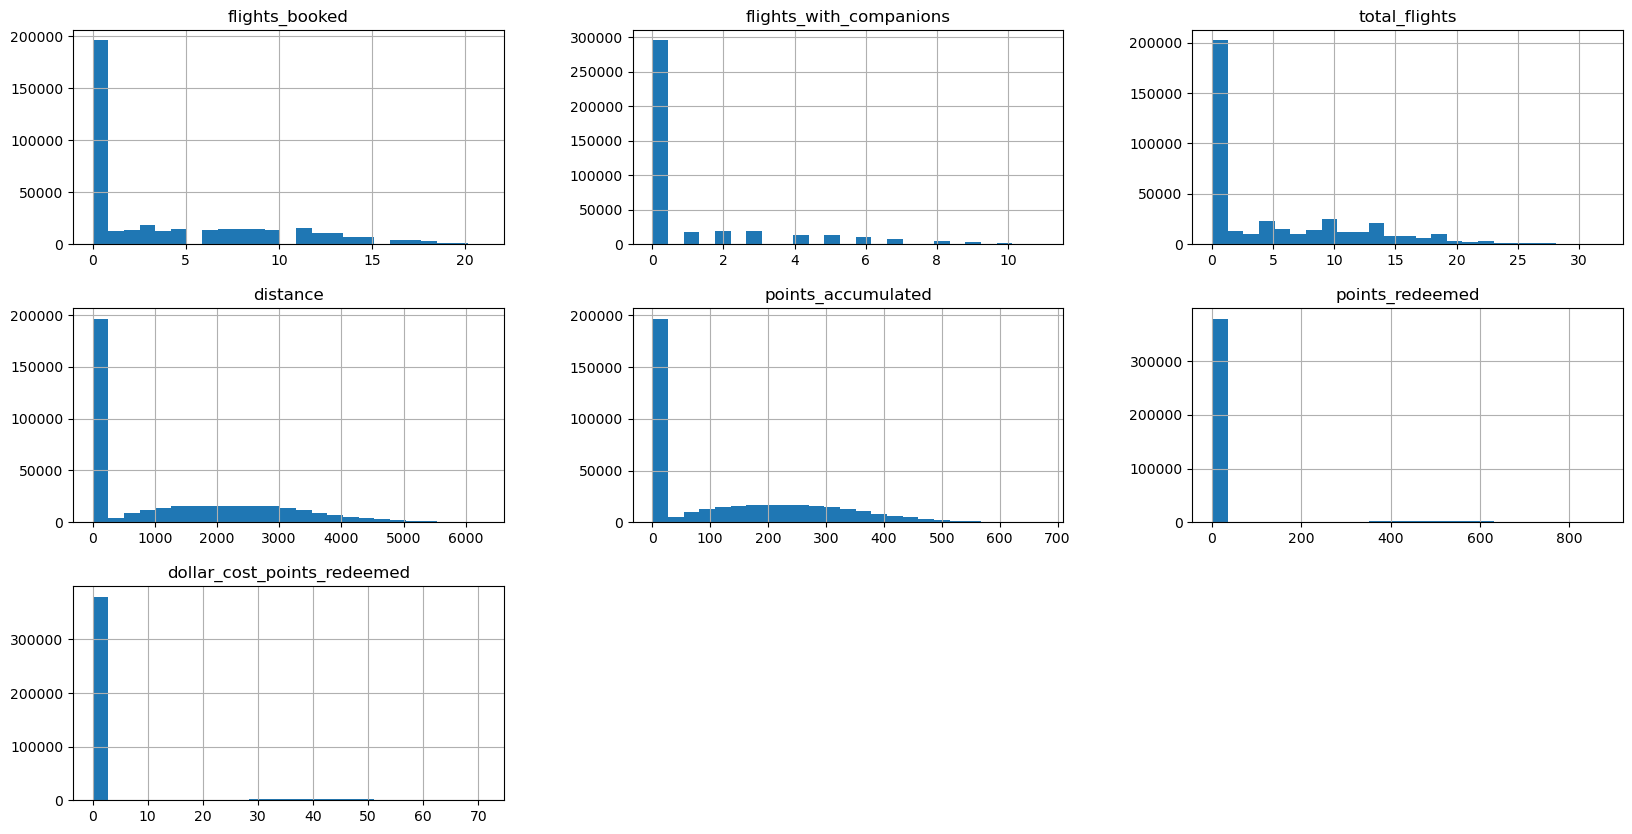

In [456]:
# realizar un histograma para verificar la distribución de los datos en las columnas

df_flight[['flights_booked', 'flights_with_companions', 'total_flights', 'distance',
       'points_accumulated', 'points_redeemed', 'dollar_cost_points_redeemed']].hist(bins=25, figsize=(20,10));

In [457]:
# en las gráficas anteriores vemos que los valores '0' distorcionan mucho los datos, 
# ya que existe una cantidad de clientes en nuestra base de datos que no tienen registrado ningún vuelo aún

df_flight.head(20)

,loyalty_number,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
0,100018,2017,Enero,3,0,3,1521,152,0,0
1,100102,2017,Enero,10,4,14,2030,203,0,0
2,100140,2017,Enero,6,0,6,1200,120,0,0
3,100214,2017,Enero,0,0,0,0,0,0,0
4,100272,2017,Enero,0,0,0,0,0,0,0
5,100301,2017,Enero,0,0,0,0,0,0,0
6,100364,2017,Enero,0,0,0,0,0,0,0
7,100380,2017,Enero,0,0,0,0,0,0,0
8,100428,2017,Enero,6,0,6,606,60,0,0
9,100504,2017,Enero,0,0,0,0,0,0,0


In [458]:
# crear un DataFrame que filtre los 'clientes activos' para analizar mejor su actividad
# filtramos por 'total_flights', ya que si no hay valores en esta columna no se registran datos en las demás columnas

df_flight_active = df_flight[df_flight['total_flights'] > 0] # filtramos para que guarde registros mayores a '0'
df_flight_active.head(10) # imprimir el DataFrame para verificar

,loyalty_number,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
0,100018,2017,Enero,3,0,3,1521,152,0,0
1,100102,2017,Enero,10,4,14,2030,203,0,0
2,100140,2017,Enero,6,0,6,1200,120,0,0
8,100428,2017,Enero,6,0,6,606,60,0,0
10,100550,2017,Enero,3,0,3,2037,203,0,0
11,863070,2017,Septiembre,8,7,15,4245,424,341,28
16,100727,2017,Enero,11,0,11,1144,114,0,0
18,100753,2017,Enero,8,4,12,3264,326,0,0
19,100816,2017,Enero,9,1,10,2340,234,0,0
20,100853,2017,Enero,6,6,12,1236,123,0,0


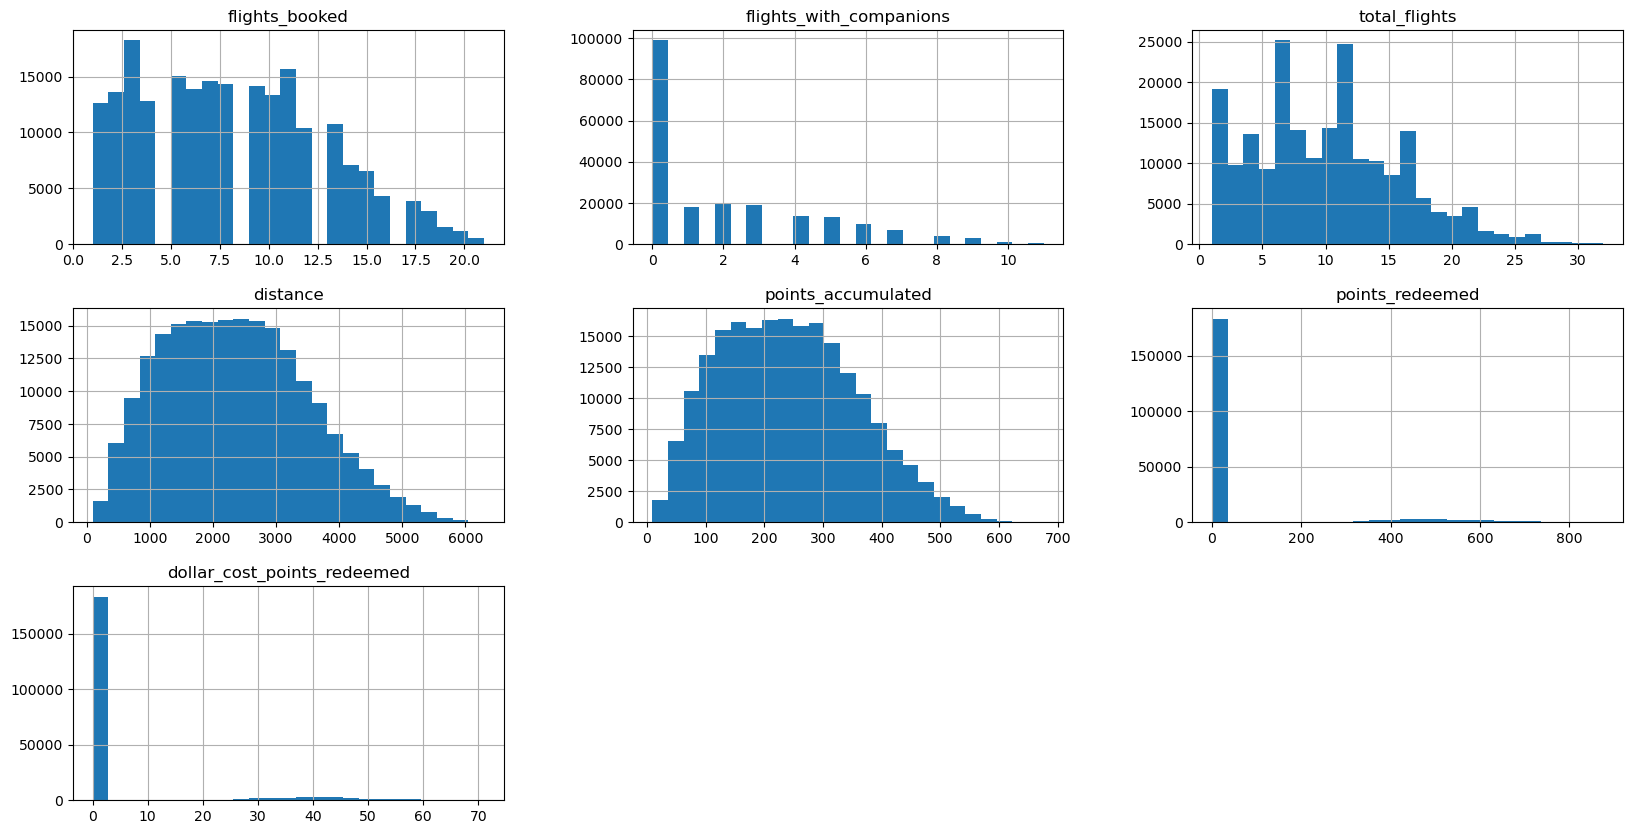

In [459]:
# con el DataFrame de 'clientes activos' podemos visualizar mejor las gráficas:

df_flight_active[['flights_booked', 'flights_with_companions', 'total_flights', 'distance',
                  'points_accumulated', 'points_redeemed', 'dollar_cost_points_redeemed']].hist(bins=25, figsize=(20,10));

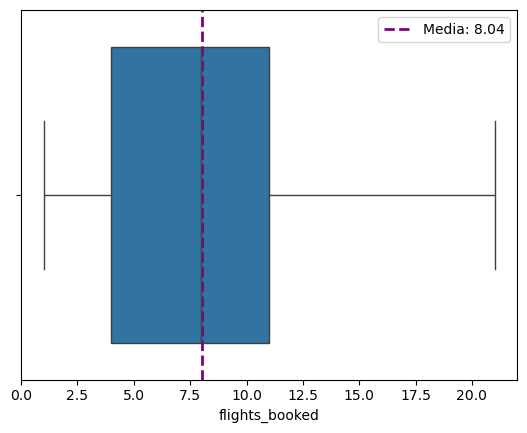

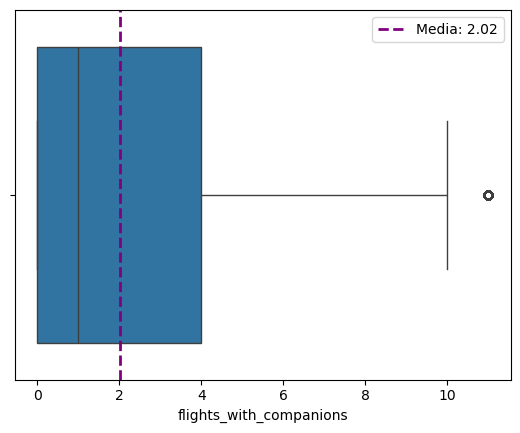

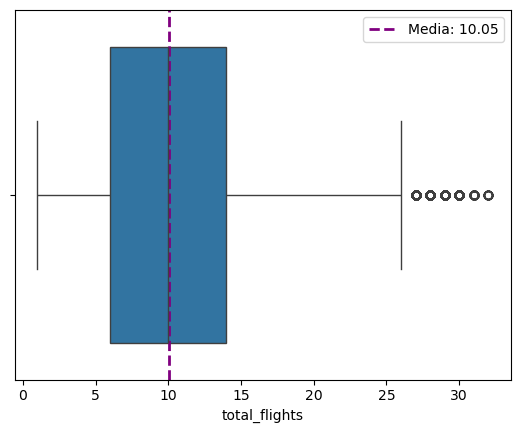

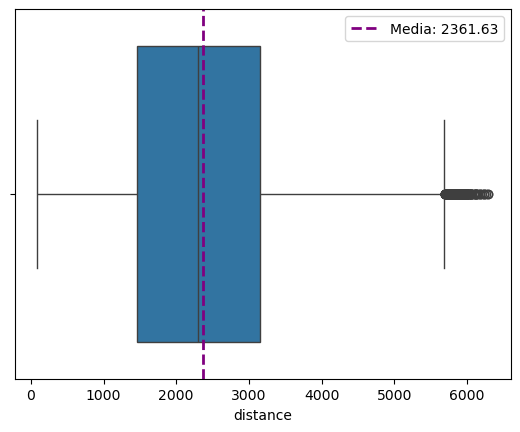

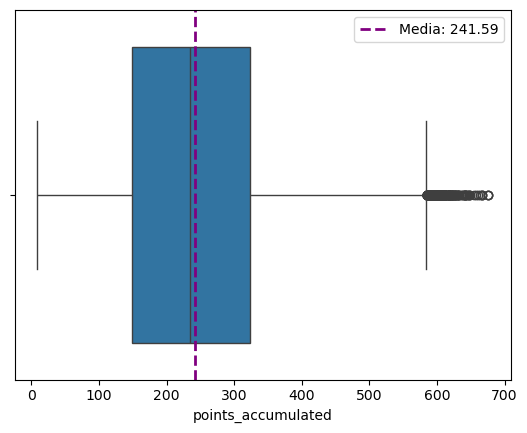

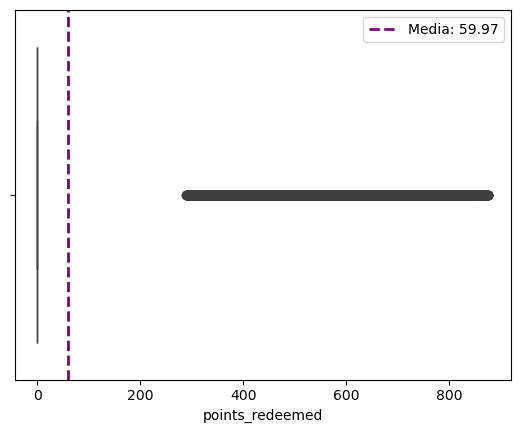

In [460]:
# usar el DataFrame con los 'clientes activos' y las columnas que nos aportan información:
# usar un bucle 'for' para que recorra los datos de las columnas seleccionadas, calcula la media de cada columna (redondeada a 2 decimales)

for col in df_flight_active[['flights_booked', 
                             'flights_with_companions', 
                             'total_flights', 
                             'distance',
                             'points_accumulated',
                             'points_redeemed']].columns:
    media_col = round(df_flight_active[col].mean(), 2) # se incorpora la media en el gráfico
    sns.boxplot(data=df_flight_active, x=col)
    plt.axvline(x=media_col, color='purple', linestyle='--', linewidth=2, label=f'Media: {media_col}')
    plt.legend()
    plt.show();

### Algunas conclusiones:

- Muchos clientes tienen entre 4 y 11 vuelos reservados, que corresponde un poco con la gráfica de 'total_flights' (entre 5 y 15 vuelos totales aproximadamente).

- La media de vuelos reservados es de 8 por cliente, y la media de vuelos totales es 10. Se podría decir que se realizan la mayoría de vuelos reservados.

- Pocos clientes han realizado mas de 25 vuelos.

- En su mayoría los vuelos han sido sin acompañantes (vuelos individuales) con una media de 2.

- La gran parte de los vuelos son de distancias cortas: entre 1.500 y 3.000. Pocos clientes han realizado vuelos mas largos.

- Los clientes acumulan puntos por distancia de vuelo, entre 150 y 300 puntos (que se puede corresponder a la distancia de vuelo).

- Se puede concluir que la gran mayoría no han utilizado estos puntos acumulados por vuelos realizados, ya que la media de los puntos usados se encuentra en 500 (tomando en cuenta que la mayoría de clientes tiene entre 150 y 300 puntos actualmente, 240 de media).

- Se han realizado mas vuelos en 2018 comparado con 2017.

- El mes en el que mas vuelos se han registrado ha sido 'Noviembre'

---

In [461]:
# 7. Se verifica la cantidad de nulos que tenemos en el DataFrame usando las funciones 'isnull()' y 'sum()'

df_flight.isnull().sum() 
# no tenemos datos nulos en ninguna de las columnas

loyalty_number                 0
year                           0
month                          0
flights_booked                 0
flights_with_companions        0
total_flights                  0
distance                       0
points_accumulated             0
points_redeemed                0
dollar_cost_points_redeemed    0
dtype: int64

In [462]:
# comprobar el total de registros. 
# Tenemos el archivo limpio de duplicados, nulos, nombres de columnas consistentes y datos apropiados

df_flight.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 403760 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   loyalty_number               403760 non-null  int64 
 1   year                         403760 non-null  object
 2   month                        403760 non-null  object
 3   flights_booked               403760 non-null  int64 
 4   flights_with_companions      403760 non-null  int64 
 5   total_flights                403760 non-null  int64 
 6   distance                     403760 non-null  int64 
 7   points_accumulated           403760 non-null  int32 
 8   points_redeemed              403760 non-null  int64 
 9   dollar_cost_points_redeemed  403760 non-null  int64 
dtypes: int32(1), int64(7), object(2)
memory usage: 32.3+ MB


## II. Trabajamos con el DataFrame de información sobre el perfil de los clientes y detalles de su membresía.

#### DataFrame: `df_loyalty`

---

In [463]:
# 1. Explorar una visión general del DataFrame:

display(df_loyalty.head(2)) # visualizar los primeros datos del DataFrame
print('***' * 40)
display(df_loyalty.tail(2)) # visualizar los últimos datos del DataFrame
print('***' * 40)
display(df_loyalty.sample(2)) # visualizar datos aleatorios del DataFrame

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN


************************************************************************************************************************


,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
16735,906428,Canada,Yukon,Whitehorse,Y2K 6R0,Male,Bachelor,-57297.0,Married,Star,10018.66,2018 Promotion,2018,4,NaN,NaN
16736,652627,Canada,Manitoba,Winnipeg,R2C 0M5,Female,Bachelor,75049.0,Married,Star,83325.38,Standard,2015,12,2016.0,8.0


************************************************************************************************************************


,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
7248,324125,Canada,Ontario,Toronto,M2Z 4K1,Male,High School or Below,50200.0,Married,Nova,6494.24,Standard,2018,7,NaN,NaN
10066,355102,Canada,British Columbia,Vancouver,V6E 3D9,Female,College,NaN,Single,Star,2279.75,Standard,2018,1,NaN,NaN


In [464]:
# observaciones:
# vemos que hay algunos salarios en negativo y hay valores faltantes
# los datos de 'Enrollment Month' está en número, se podría cambiar al nombre de los meses y tratar como una columna categórica
# faltan valores en la columna de 'Cancellation Year' y 'Cancellation Month'. Están de tipo 'float', se podría cambiar a 'int'
# 'Enrollment Type' tiene valores numéricos (año) y categóricos, se podría tratar como uan columnas de tipo categórico

In [465]:
# explorar el número de filas y columnas del DataFrame usando el método '.shape' 
# indicando el índice del array (0 para filas y 1 para columnas):
 
print(f"El número de filas es {df_loyalty.shape[0]}, el número de columnas es {df_loyalty.shape[1]}")

El número de filas es 16737, el número de columnas es 16


In [466]:
# exploramos los nombres de las columnas:

df_loyalty.columns

# obervación: vemos que hay un patrón consistente en el nombre de las columnas (todos en inglés) 
# pero se decide modificar todos los nombres a minúsculas y las palabras separadas por '_' en lugar de espacios
# pensando en luego hacer una inserción de datos usando Python + SQL

Index(['Loyalty Number', 'Country', 'Province', 'City', 'Postal Code',
       'Gender', 'Education', 'Salary', 'Marital Status', 'Loyalty Card',
       'CLV', 'Enrollment Type', 'Enrollment Year', 'Enrollment Month',
       'Cancellation Year', 'Cancellation Month'],
      dtype='object')

In [467]:
# crear un nuevo diccionario para reemplazar el nombre de las columnas con nlas nuevas condiciones
# usando una 'list comprehension para iteractuar por cada nombre de columna en el DataFrame

nuevas_columnas2 = {col: col.lower().replace(' ','_') for col in df_loyalty.columns}
nuevas_columnas2 # imprime el diccionario con el nombre original y el nombre con nomenclatura unificada

{'Loyalty Number': 'loyalty_number',
 'Country': 'country',
 'Province': 'province',
 'City': 'city',
 'Postal Code': 'postal_code',
 'Gender': 'gender',
 'Education': 'education',
 'Salary': 'salary',
 'Marital Status': 'marital_status',
 'Loyalty Card': 'loyalty_card',
 'CLV': 'clv',
 'Enrollment Type': 'enrollment_type',
 'Enrollment Year': 'enrollment_year',
 'Enrollment Month': 'enrollment_month',
 'Cancellation Year': 'cancellation_year',
 'Cancellation Month': 'cancellation_month'}

In [468]:
# aplicar el cambio de nombre de columnas usando el diccionario creado usando la función 'rename()'

df_loyalty.rename(columns = nuevas_columnas2, inplace=True)
df_loyalty.columns # comprobar los cambios realizados

Index(['loyalty_number', 'country', 'province', 'city', 'postal_code',
       'gender', 'education', 'salary', 'marital_status', 'loyalty_card',
       'clv', 'enrollment_type', 'enrollment_year', 'enrollment_month',
       'cancellation_year', 'cancellation_month'],
      dtype='object')

In [469]:
# 2. Exploramos la información del DataFrame:

df_loyalty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loyalty_number      16737 non-null  int64  
 1   country             16737 non-null  object 
 2   province            16737 non-null  object 
 3   city                16737 non-null  object 
 4   postal_code         16737 non-null  object 
 5   gender              16737 non-null  object 
 6   education           16737 non-null  object 
 7   salary              12499 non-null  float64
 8   marital_status      16737 non-null  object 
 9   loyalty_card        16737 non-null  object 
 10  clv                 16737 non-null  float64
 11  enrollment_type     16737 non-null  object 
 12  enrollment_year     16737 non-null  int64  
 13  enrollment_month    16737 non-null  int64  
 14  cancellation_year   2067 non-null   float64
 15  cancellation_month  2067 non-null   float64
dtypes: f

### Primeras conclusiones de la exploración de datos del DataFrame:

- Existen datos nulos que debemos gestionar antes de las visualizaciones en 'salary', 'cancellation_year, 'cancellation_month'.

- Existen datos negativos en 'salary' que debemos gestionar (no deberían haber salarios con valores negativos).

- Las columnas tienen nombres unificados, por lo que no haremos cambios.

- Los datos en 'enrollment_month' y 'cancellation_month' están expresados en número de los meses. Se podría cambiar al nombre de los meses y tratar como una columna categórica.

- Los datos de las columnas 'enrollment_year' y 'enrollment_month' están de tipo 'int'. Se podría cambiar a 'object/str' y convertir a datos categóricos.

- Los datos de las columnas 'cancellation_year' y 'cancellation_month' están de tipo 'float'. Se decide cambiar de tipo de dato 'object/str' y convertir a datos categóricos.

---

In [470]:
# 3. Exploramos la cantidad de nulos que tenemos en el DataFrame usando las funciones 'isnull()' y 'sum()'
# gran cantidad de valores faltantes en el DataFrame y para que no afecte los análisis siguientes se decide gestionarlos

df_loyalty.isnull().sum()

# confirmamos que las columnas con datos nulos son 'salary', 'cancellation_year', 'cancellation_month'

loyalty_number            0
country                   0
province                  0
city                      0
postal_code               0
gender                    0
education                 0
salary                 4238
marital_status            0
loyalty_card              0
clv                       0
enrollment_type           0
enrollment_year           0
enrollment_month          0
cancellation_year     14670
cancellation_month    14670
dtype: int64

In [471]:
# para decidir como gestionar los nulos de estas columnas debemos verlo en porcentaje
# usando el método '.shape' con índice '0' que selecciona las filas

df_loyalty.isnull().sum()/df_loyalty.shape[0]*100 # para verlo en porcentaje

loyalty_number         0.000000
country                0.000000
province               0.000000
city                   0.000000
postal_code            0.000000
gender                 0.000000
education              0.000000
salary                25.321145
marital_status         0.000000
loyalty_card           0.000000
clv                    0.000000
enrollment_type        0.000000
enrollment_year        0.000000
enrollment_month       0.000000
cancellation_year     87.650117
cancellation_month    87.650117
dtype: float64

In [472]:
# podemos representar los nulos en un DataFrame, para mejor visualización que nos ayude a tomar decisiones

nulos = round((df_loyalty.isnull().sum()/df_loyalty.shape[0]*100), 2).reset_index() # guardamos los datos en porcentaje en una variable

nulos.rename(columns={'index': 'columna', 0:'% nulos'}, inplace=True) # reenombrar las columnas del nuevo DataFrame
mascara = nulos['% nulos'] > 0 # filtramos par que nos muestre los valores mayor a '0'
nulos = nulos[mascara]
nulos

,columna,% nulos
7,salary,25.32
14,cancellation_year,87.65
15,cancellation_month,87.65


### Conclusiones gestión de nulos:

Comprobamos que 'salary' tiene un 25% de nulos. Las columnas 'cancellation_year' y 'cancellation_month' 88% de valores nulos.

En ningún caso podemos imputar estos valores por la media/mediana, por lo que se debe generar una nueva categoría/valor para imputar:

- 'No data' para los datos de cancelación ('cancellation_year' y 'cancellation_month'), ya que podríamos deducir que estos clientes no han cancelado sus registro en el programa de lealtad. Puede ser un dato que se puede actualizar en el futuro.

- Para los datos de salario (salary), ya que podemos intuir que el cliente no proporcionó este dato a la hora del registro, reemplazamos los valores nulos por el valor '0', que luedo podemos filtrar para los siguientes análisis. En un futuro cuando se tengan estos datos, se podría actualizar esta columna.

---

In [473]:
# en primer lugar gestionar la columna 'salary':
# visualizamos los datos en negativo que existen en la columna 'salary' 
# se debe verificar si es un error de entrada, y si son casos aislados determinar la razón

print(df_loyalty['salary'].describe()) # proporciona información sobre los datos en negativo
print('***' * 40)
display(df_loyalty[df_loyalty['salary'] < 0].head(20)) # filtra los datos menor que '0' (negativos)
print('***' * 40)
print(df_loyalty[df_loyalty['salary'] < 0].count()) # conteo de cuantas filas hay con datos en negativos

count     12499.000000
mean      79245.609409
std       35008.297285
min      -58486.000000
25%       59246.500000
50%       73455.000000
75%       88517.500000
max      407228.000000
Name: salary, dtype: float64
************************************************************************************************************************


,loyalty_number,country,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month
1082,542976,Canada,Quebec,Montreal,H2Y 4R4,Male,High School or Below,-49830.0,Divorced,Star,24127.50,2018 Promotion,2018,3,NaN,NaN
1894,959977,Canada,British Columbia,Vancouver,V5R 1W3,Female,Bachelor,-12497.0,Married,Aurora,9453.00,2018 Promotion,2018,3,NaN,NaN
2471,232755,Canada,British Columbia,Vancouver,V1E 4R6,Female,Bachelor,-46683.0,Single,Nova,4787.81,2018 Promotion,2018,3,NaN,NaN
3575,525245,Canada,British Columbia,Victoria,V10 6T5,Male,Bachelor,-45962.0,Married,Star,2402.33,2018 Promotion,2018,3,NaN,NaN
3932,603070,Canada,British Columbia,West Vancouver,V6V 8Z3,Female,Bachelor,-19325.0,Single,Star,2893.74,2018 Promotion,2018,3,NaN,NaN
4712,491242,Canada,British Columbia,Dawson Creek,U5I 4F1,Male,Bachelor,-43234.0,Married,Star,7597.91,2018 Promotion,2018,3,NaN,NaN
6560,115505,Canada,Newfoundland,St. John's,A1C 6H9,Male,Bachelor,-10605.0,Married,Nova,5860.17,2018 Promotion,2018,4,NaN,NaN
6570,430398,Canada,Newfoundland,St. John's,A1C 6H9,Male,Bachelor,-17534.0,Married,Nova,49423.80,2018 Promotion,2018,3,NaN,NaN
7373,152016,Canada,Ontario,Toronto,P1J 8T7,Female,Bachelor,-58486.0,Married,Aurora,5067.21,2018 Promotion,2018,2,NaN,NaN
8576,194065,Canada,Ontario,Sudbury,M5V 1G5,Female,Bachelor,-31911.0,Married,Nova,2888.85,2018 Promotion,2018,2,NaN,NaN


************************************************************************************************************************
loyalty_number        20
country               20
province              20
city                  20
postal_code           20
gender                20
education             20
salary                20
marital_status        20
loyalty_card          20
clv                   20
enrollment_type       20
enrollment_year       20
enrollment_month      20
cancellation_year      2
cancellation_month     2
dtype: int64


In [474]:
# se decide convertir los valores negativos en positivos usando la función 'abs()'
# abs: nos devuelve el valor absoluto del numero, que siempre será positivo

df_loyalty['salary'] = df_loyalty['salary'].abs() 
df_loyalty.head(20) # imprimimos los primeros 20 datos del DataFrame para comprobar el cambio

,loyalty_number,country,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018.0,1.0
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,NaN,NaN
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,NaN,NaN
5,193662,Canada,Yukon,Whitehorse,Y2K 6R0,Male,Bachelor,51124.0,Married,Star,3844.57,Standard,2012,5,NaN,NaN
6,927943,Canada,Ontario,Toronto,P5S 6R4,Female,College,NaN,Single,Star,3857.95,Standard,2014,6,NaN,NaN
7,188893,Canada,Ontario,Trenton,K8V 4B2,Male,Bachelor,100159.0,Married,Star,3861.49,Standard,2016,12,NaN,NaN
8,852392,Canada,Quebec,Montreal,H2Y 2W2,Female,Bachelor,100159.0,Married,Star,3861.49,Standard,2015,5,NaN,NaN
9,866307,Canada,Ontario,Toronto,M8Y 4K8,Male,Bachelor,100159.0,Married,Star,3861.49,Standard,2016,10,NaN,NaN


In [475]:
# primero verificar la cantidad de nulos en la columna 'salary' usando las funciones 'isnull()' y 'sum()'

df_loyalty['salary'].isnull().sum()

4238

In [476]:
# imputar los nulos con un nuevo valor '0' en la columna 'salary' usando las funciones 'value_counts()' y 'fillna()'

df_loyalty['salary'].value_counts(normalize=True)
df_loyalty['salary'] = df_loyalty['salary'].fillna(0)

# para verificar los cambios
print(df_loyalty['salary'].isnull().sum()) # para obtener la suma total de nulos, si existe
display(df_loyalty.head(10)) # imprimimos los primeros 10 datos del DataFrame para comprobar el cambio

0


,loyalty_number,country,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,0.0,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,0.0,Single,Star,3839.75,Standard,2014,7,2018.0,1.0
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,0.0,Single,Star,3839.75,Standard,2013,2,NaN,NaN
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,NaN,NaN
5,193662,Canada,Yukon,Whitehorse,Y2K 6R0,Male,Bachelor,51124.0,Married,Star,3844.57,Standard,2012,5,NaN,NaN
6,927943,Canada,Ontario,Toronto,P5S 6R4,Female,College,0.0,Single,Star,3857.95,Standard,2014,6,NaN,NaN
7,188893,Canada,Ontario,Trenton,K8V 4B2,Male,Bachelor,100159.0,Married,Star,3861.49,Standard,2016,12,NaN,NaN
8,852392,Canada,Quebec,Montreal,H2Y 2W2,Female,Bachelor,100159.0,Married,Star,3861.49,Standard,2015,5,NaN,NaN
9,866307,Canada,Ontario,Toronto,M8Y 4K8,Male,Bachelor,100159.0,Married,Star,3861.49,Standard,2016,10,NaN,NaN


In [477]:
# convertir los datos de tipo 'float' a tipo 'int' usando la función 'astype()'
# Recomendamos a la empresa: Para futuros registros estos deben ser ingresdaos en números enteros actualizando los valores '0'

df_loyalty['salary'] = df_loyalty['salary'].astype(int)
df_loyalty.info() # imprimimos la información del DataFrame para comprobar el cambio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loyalty_number      16737 non-null  int64  
 1   country             16737 non-null  object 
 2   province            16737 non-null  object 
 3   city                16737 non-null  object 
 4   postal_code         16737 non-null  object 
 5   gender              16737 non-null  object 
 6   education           16737 non-null  object 
 7   salary              16737 non-null  int32  
 8   marital_status      16737 non-null  object 
 9   loyalty_card        16737 non-null  object 
 10  clv                 16737 non-null  float64
 11  enrollment_type     16737 non-null  object 
 12  enrollment_year     16737 non-null  int64  
 13  enrollment_month    16737 non-null  int64  
 14  cancellation_year   2067 non-null   float64
 15  cancellation_month  2067 non-null   float64
dtypes: f

In [478]:
# hacemos otra comprobación del DataFrame, de las columnas que quedan por gestionar

print(df_loyalty.isnull().sum())

loyalty_number            0
country                   0
province                  0
city                      0
postal_code               0
gender                    0
education                 0
salary                    0
marital_status            0
loyalty_card              0
clv                       0
enrollment_type           0
enrollment_year           0
enrollment_month          0
cancellation_year     14670
cancellation_month    14670
dtype: int64


In [479]:
# comprobar el tipo de datos de estas columnas

print(df_loyalty[['cancellation_year', 'cancellation_month']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cancellation_year   2067 non-null   float64
 1   cancellation_month  2067 non-null   float64
dtypes: float64(2)
memory usage: 261.6 KB
None


In [480]:
# decidir convertir los datos de tipo 'float' a 'int' y eliminar los decimales, usando la función 'astype()'
# para luego convertirlo a tipo 'object' en las columnas 'cancellation_year' y 'cancellation_month'

df_loyalty[['cancellation_year', 'cancellation_month']] = df_loyalty[['cancellation_year', 'cancellation_month']].astype('Int64')
df_loyalty[['cancellation_year', 'cancellation_month']].info() # imprimimos la información del DataFrame para comprobar el cambio

# el tipo 'Int64' considera los NaN y no los modifica para poder realizar imputaciones

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   cancellation_year   2067 non-null   Int64
 1   cancellation_month  2067 non-null   Int64
dtypes: Int64(2)
memory usage: 294.3 KB


In [481]:
# imputar los nulos con '0' que luego se usará en el mapa de los nombres de los meses como una nueva categoría
# usar las funciones 'value_counts()' y 'fillna()'

df_loyalty[['cancellation_year', 'cancellation_month']].value_counts(normalize=True)
df_loyalty[['cancellation_year', 'cancellation_month']] = df_loyalty[['cancellation_year', 'cancellation_month']].fillna(0)
print(df_loyalty[['cancellation_year', 'cancellation_month']].isnull().sum()) # para verificar si ya no hay nulos en los datos

cancellation_year     0
cancellation_month    0
dtype: int64


In [482]:
# luego de gestionar los nulos en estas columnas, verificar los datos nuevamente:

df_loyalty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loyalty_number      16737 non-null  int64  
 1   country             16737 non-null  object 
 2   province            16737 non-null  object 
 3   city                16737 non-null  object 
 4   postal_code         16737 non-null  object 
 5   gender              16737 non-null  object 
 6   education           16737 non-null  object 
 7   salary              16737 non-null  int32  
 8   marital_status      16737 non-null  object 
 9   loyalty_card        16737 non-null  object 
 10  clv                 16737 non-null  float64
 11  enrollment_type     16737 non-null  object 
 12  enrollment_year     16737 non-null  int64  
 13  enrollment_month    16737 non-null  int64  
 14  cancellation_year   16737 non-null  Int64  
 15  cancellation_month  16737 non-null  Int64  
dtypes: I

In [483]:
# convertir los datos de tipo 'int' a 'object; en las columnas 'enrollment_year', 'enrollment_month', 'cancellation_year' y 'cancellation_month'

df_loyalty[['enrollment_year', 'enrollment_month', 'cancellation_year', 'cancellation_month']] = df_loyalty[['enrollment_year', 'enrollment_month', 'cancellation_year', 'cancellation_month']].astype(str)
df_loyalty[['enrollment_year', 'enrollment_month', 'cancellation_year', 'cancellation_month']].info() # imprimimos la información del DataFrame para comprobar el cambio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   enrollment_year     16737 non-null  object
 1   enrollment_month    16737 non-null  object
 2   cancellation_year   16737 non-null  object
 3   cancellation_month  16737 non-null  object
dtypes: object(4)
memory usage: 523.2+ KB


In [484]:
# convertir los números de los meses por los nombre de los meses para mejor comprensión
# usando una diccionario como máscara que asigna a cada numero un nombre de mes, y a los nulos '0' se le imputa la nueva categoría

mapa_mes2 = {'0': 'Sin data', '1': 'Enero', '2': 'Febrero', '3': 'Marzo', '4': 'Abril', '5': 'Mayo', '6': 'Junio', 
            '7': 'Julio', '8': 'Agosto', '9': 'Septiembre', '10': 'Octubre', '11': 'Noviembre', '12': 'Diciembre'}

for col in df_loyalty[['enrollment_month','cancellation_month', 'cancellation_year']].columns:
    df_loyalty[col] = df_loyalty[col].replace(mapa_mes2)
    print(df_loyalty[col].unique())

# usamos 'replace' para que no afecte los valores no nulos que tenemos en las columnas 'cancellation_month', 'cancellation_year'
# comprobamos que en las columnas de 'enrollment_month' que no tenía nulos, hay 12 nuevos datos con los nombres de los meses
# en cambio en 'cancellation_month' que tenemos nulos imputados con '0', se reemplazan por 'Sin data' (13 tipos de categorías)
# en 'cancellation_year' tenemos datos nulos reemplazados por 'Sin data' y el resto al no estar dentro del mapa se quedan como están

['Febrero' 'Marzo' 'Julio' 'Octubre' 'Mayo' 'Junio' 'Diciembre' 'Enero'
 'Noviembre' 'Agosto' 'Abril' 'Septiembre']
['Sin data' 'Enero' 'Diciembre' 'Abril' 'Febrero' 'Julio' 'Noviembre'
 'Mayo' 'Junio' 'Octubre' 'Agosto' 'Septiembre' 'Marzo']
['Sin data' '2018' '2015' '2017' '2014' '2016' '2013']


In [485]:
# 4. Explorar los datos de las columnas categóricas usando la función 'describe()'

df_loyalty.describe(include='O').T

,count,unique,top,freq
country,16737,1,Canada,16737
province,16737,11,Ontario,5404
city,16737,29,Toronto,3351
postal_code,16737,55,V6E 3D9,911
gender,16737,2,Female,8410
education,16737,5,Bachelor,10475
marital_status,16737,3,Married,9735
loyalty_card,16737,3,Star,7637
enrollment_type,16737,2,Standard,15766
enrollment_year,16737,7,2018,3010


In [486]:
# observaciones: 
# el pais de estudio es Canada
# la provincia con mas clientes registrados en 'Ontario' y la ciudad 'Toronto'
# hay mas registros de clientes mujeres
# el nivel educativo de predominancia es 'Bachelor' y status marital 'Married'
# la tarjeta de lealtad que mas registros tiene es 'Star' y el tipo de registro predominante es 'Standard'
# el año con mas registro fue 2018 y el mes con mas registros 'Mayo'
# la mayoría de clientes no han cancelado sus registros de la base de datos

In [487]:
# exploramos los datos de las columnas numéricas usando la función 'describe()'

df_loyalty.describe().T

# concluímos que la media y la mediana no están cercanas en los datos 'clv' pero estan mas próximas en 'salary' 
# y la dispersión de los datos es alta

,count,mean,std,min,25%,50%,75%,max
loyalty_number,16737.0,549735.880445,258912.132453,100018.00,326603.00,550434.00,772019.00,999986.00
salary,16737.0,59264.647308,45746.427785,0.00,0.00,63654.00,82940.00,407228.00
clv,16737.0,7988.896536,6860.982280,1898.01,3980.84,5780.18,8940.58,83325.38


In [488]:
# 5. Exploramos el DataFrame para detectar registros duplicados

df_loyalty.duplicated().sum() # usar las funciones 'duplicated()' y 'sum()'
# no se registran datos duplicados en el DataFrame

0

In [489]:
# 6. Análisis de las variables categóricas, usando funciones de 'select_dtypes()' y 'value_count()' dentro de un bucle 'for'

for col in df_loyalty.select_dtypes(include='O').columns:
    print(f"Columna --> {col}")
    print(f"{df_loyalty[col].value_counts()}") # nos muestra las veces que aparece un dato en cada categoría
    print('***' * 25)

Columna --> country
country
Canada    16737
Name: count, dtype: int64
***************************************************************************
Columna --> province
province
Ontario                 5404
British Columbia        4409
Quebec                  3300
Alberta                  969
Manitoba                 658
New Brunswick            636
Nova Scotia              518
Saskatchewan             409
Newfoundland             258
Yukon                    110
Prince Edward Island      66
Name: count, dtype: int64
***************************************************************************
Columna --> city
city
Toronto           3351
Vancouver         2582
Montreal          2059
Winnipeg           658
Whistler           582
Halifax            518
Ottawa             509
Trenton            486
Edmonton           486
Quebec City        485
Dawson Creek       444
Fredericton        425
Regina             409
Kingston           401
Tremblant          398
Victoria           389
Hull         

In [490]:
# observaciones: 
# 'Ontario' es la Provincia dominante y 'Toronto' donde vive la mayoría de los clientes
# Los registros han subido cada año, significativamente en el 2018. No tenemos registros del 2013 y 2014
# El mes que mas registros tenemos es Mayo, seguido de Diciembre en segundo lugar
# Hay muchos clientes que han cancelado su registro, pero el año que mas de registraron cancelaciones fue en 2018 y el mes de Diciembre

In [491]:
# 7. Análisis de las variables numéricas, usando las herramientas de visualización 'hist' y 'boxplot'
# seleccionar las columnas que aportan información

df_loyalty.select_dtypes(include='number').columns # por el tipo de datos numéricos

Index(['loyalty_number', 'salary', 'clv'], dtype='object')

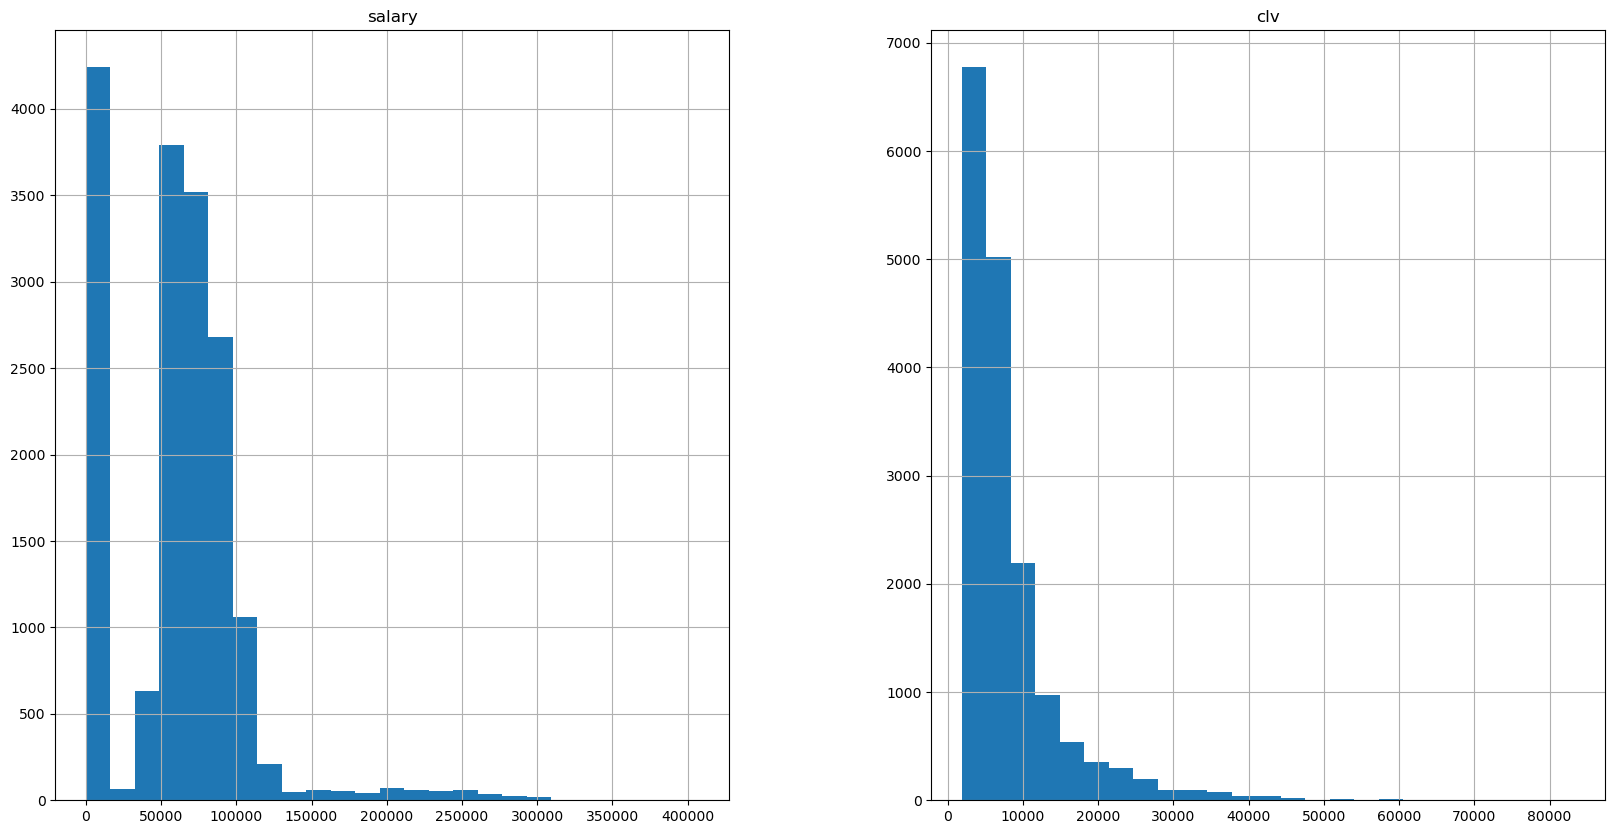

In [492]:
# # realizar un histograma para verificar la distribución de los datos en las columnas 'salary' y 'clv'
# Customer lifetime value (CLV): son los ingresos o ganancias totales generados por un cliente durante todo el transcurso de la relación con la empresa

df_loyalty[['salary', 'clv']].hist(bins=25, figsize=(20,10));

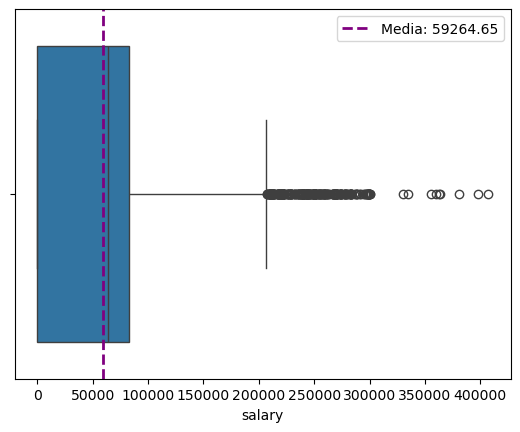

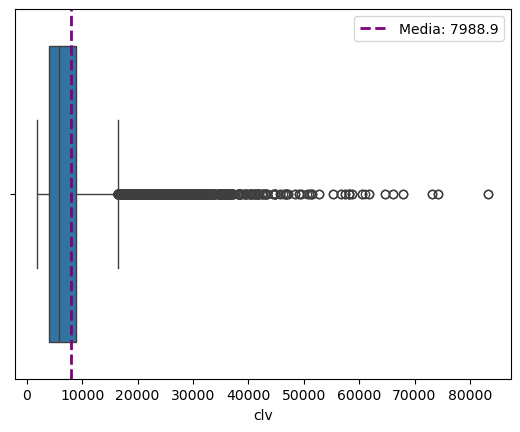

In [493]:
# usar las columnas que nos aportan información
# usar un bucle 'for' para que recorra los datos de las columnas seleccionadas, calcula la media de cada columna (redondeada a 2 decimales)

for col in df_loyalty[['salary', 'clv']].columns:
    media_col = round(df_loyalty[col].mean(), 2) # se incorpora la media en el gráfico
    sns.boxplot(data=df_loyalty, x=col)
    plt.axvline(x=media_col, color='purple', linestyle='--', linewidth=2, label=f'Media: {media_col}')
    plt.legend()
    plt.show();

### Algunas conclusiones:

- Se nota una gran cantidad de valores atípicos en la gráfica de salario y CLV, desde los 200.000 y 20.000 respectivamente.

- Se puede intuir que hay una relación directa y positiva entre el salario y el profit que los clientes generan.

- La mayoría de los clientes tienen un salario menor a los 100.000, que generan menos de 10.000 en ganancias.

- La mediana y la media se ven afectados por esos valores atípicos, siendo la media en 60K aprox. para el salario y 8K aprox. de media de ganancia.

---

## III. Trabajamos con los DataFrame con información de vuelos y de clientes, ya limpios y analizados individualmente para unirlos en un solo DataFrame

#### DataFrame: `df_complete`

---

In [494]:
# verificamos la información y datos de cada DataFrame, para seleccionar la columna de unión

display(df_flight.head())
display(df_loyalty.head())

,loyalty_number,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
0,100018,2017,Enero,3,0,3,1521,152,0,0
1,100102,2017,Enero,10,4,14,2030,203,0,0
2,100140,2017,Enero,6,0,6,1200,120,0,0
3,100214,2017,Enero,0,0,0,0,0,0,0
4,100272,2017,Enero,0,0,0,0,0,0,0


,loyalty_number,country,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236,Married,Star,3839.14,Standard,2016,Febrero,Sin data,Sin data
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,0,Divorced,Star,3839.61,Standard,2016,Marzo,Sin data,Sin data
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,0,Single,Star,3839.75,Standard,2014,Julio,2018,Enero
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,0,Single,Star,3839.75,Standard,2013,Febrero,Sin data,Sin data
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495,Married,Star,3842.79,Standard,2014,Octubre,Sin data,Sin data


In [541]:
df_flight.info()
df_loyalty.info()

<class 'pandas.core.frame.DataFrame'>
Index: 403760 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   loyalty_number               403760 non-null  int64 
 1   year                         403760 non-null  object
 2   month                        403760 non-null  object
 3   flights_booked               403760 non-null  int64 
 4   flights_with_companions      403760 non-null  int64 
 5   total_flights                403760 non-null  int64 
 6   distance                     403760 non-null  int64 
 7   points_accumulated           403760 non-null  int32 
 8   points_redeemed              403760 non-null  int64 
 9   dollar_cost_points_redeemed  403760 non-null  int64 
dtypes: int32(1), int64(7), object(2)
memory usage: 32.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column              Non

In [544]:
# en ambos esta presente la columna 'loyalty_number'
# se decide unir ambos DataFrame por esa columna, usando la función merge que devuelve un DataFrame con las filas que coinciden
# mergeamos el DataFrame con la información de los clientes con el DataFrame que contiene la información de los vuelos

df_completo = df_flight.merge(df_loyalty, on='loyalty_number')
df_completo.head() # imprimimos las primeras 5 columnas del DataFrame para comprobar la unión

,loyalty_number,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed,country,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month
0,100018,2017,Enero,3,0,3,1521,152,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552,Married,Aurora,7919.20,Standard,2016,Agosto,Sin data,Sin data
1,100102,2017,Enero,10,4,14,2030,203,0,0,Canada,Ontario,Toronto,M1R 4K3,Male,College,0,Single,Nova,2887.74,Standard,2013,Marzo,Sin data,Sin data
2,100140,2017,Enero,6,0,6,1200,120,0,0,Canada,British Columbia,Dawson Creek,U5I 4F1,Female,College,0,Divorced,Nova,2838.07,Standard,2016,Julio,Sin data,Sin data
3,100214,2017,Enero,0,0,0,0,0,0,0,Canada,British Columbia,Vancouver,V5R 1W3,Male,Bachelor,63253,Married,Star,4170.57,Standard,2015,Agosto,Sin data,Sin data
4,100272,2017,Enero,0,0,0,0,0,0,0,Canada,Ontario,Toronto,P1L 8X8,Female,Bachelor,91163,Divorced,Star,6622.05,Standard,2014,Enero,Sin data,Sin data


In [545]:
# imprimimos la información del DataFrame para comprobar los datos y columnas

df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403760 entries, 0 to 403759
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loyalty_number               403760 non-null  int64  
 1   year                         403760 non-null  object 
 2   month                        403760 non-null  object 
 3   flights_booked               403760 non-null  int64  
 4   flights_with_companions      403760 non-null  int64  
 5   total_flights                403760 non-null  int64  
 6   distance                     403760 non-null  int64  
 7   points_accumulated           403760 non-null  int32  
 8   points_redeemed              403760 non-null  int64  
 9   dollar_cost_points_redeemed  403760 non-null  int64  
 10  country                      403760 non-null  object 
 11  province                     403760 non-null  object 
 12  city                         403760 non-null  object 
 13 

In [546]:
# explorar el número de filas y columnas del DataFrame usando el método '.shape' 
# indicando el índice del array (0 para filas y 1 para columnas):
 
print(f"El número de filas es {df_completo.shape[0]}, el número de columnas es {df_completo.shape[1]}")

El número de filas es 403760, el número de columnas es 25


In [548]:
# loyalty_number únicos hay en cada DataFrame

print(df_flight['loyalty_number'].nunique())
print(df_loyalty['loyalty_number'].nunique())

# veces aparece cada loyalty_number en df_flight, clientes que registran varios vuelos
print(df_flight['loyalty_number'].value_counts().head())

# el DataFrame df_completo es la unión de los vuelos que se enriquece con los datos de los clientes

16737
16737
loyalty_number
974875    48
736504    48
890702    48
617489    48
200519    47
Name: count, dtype: int64


## IV. Visualización para hacer consultas y responder preguntas

Dataframe: `df_flight`, `df_loyalty`, `df_completo`

---

In [498]:
# columnas en el DataFrame completo

df_completo.columns

Index(['loyalty_number', 'year', 'month', 'flights_booked',
       'flights_with_companions', 'total_flights', 'distance',
       'points_accumulated', 'points_redeemed', 'dollar_cost_points_redeemed',
       'country', 'province', 'city', 'postal_code', 'gender', 'education',
       'salary', 'marital_status', 'loyalty_card', 'clv', 'enrollment_type',
       'enrollment_year', 'enrollment_month', 'cancellation_year',
       'cancellation_month'],
      dtype='object')

In [533]:
df_completo.tail(20)

,loyalty_number,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed,country,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month
403740,999120,2018,Diciembre,9,7,16,2176,217,0,0,Canada,Quebec,Montreal,H3T 8L4,Female,Bachelor,88897,Married,Nova,3221.79,Standard,2016,Abril,Sin data,Sin data
403741,999143,2018,Diciembre,0,0,0,0,0,0,0,Canada,Ontario,Toronto,P5S 6R4,Male,Bachelor,58473,Married,Star,4861.37,Standard,2015,Julio,2016,Marzo
403742,999272,2018,Diciembre,12,8,20,3460,346,0,0,Canada,British Columbia,Victoria,V10 6T5,Female,Bachelor,84988,Married,Star,10656.88,Standard,2013,Agosto,Sin data,Sin data
403743,999891,2018,Septiembre,0,0,0,0,0,0,0,Canada,Nova Scotia,Halifax,B3J 9S2,Female,Bachelor,75616,Married,Nova,3745.37,Standard,2016,Mayo,2017,Enero
403744,999460,2018,Diciembre,0,0,0,0,0,0,0,Canada,British Columbia,Vancouver,V6E 3D9,Female,College,0,Married,Star,11875.90,Standard,2016,Julio,2016,Septiembre
403745,999498,2018,Diciembre,17,0,17,2754,275,0,0,Canada,Quebec,Montreal,H4G 3T4,Male,Bachelor,54457,Divorced,Nova,3436.13,Standard,2017,Febrero,Sin data,Sin data
403746,999513,2018,Diciembre,0,0,0,0,0,0,0,Canada,Manitoba,Winnipeg,R6Y 4T5,Female,Bachelor,93052,Married,Aurora,27064.46,Standard,2014,Julio,Sin data,Sin data
403747,999524,2018,Diciembre,11,4,15,1500,150,0,0,Canada,Quebec,Montreal,H2T 2J6,Male,College,0,Married,Aurora,14325.15,Standard,2015,Mayo,Sin data,Sin data
403748,999550,2018,Diciembre,15,0,15,2985,298,0,0,Canada,Quebec,Montreal,H2T 9K8,Female,Doctor,125167,Divorced,Star,13736.13,Standard,2014,Agosto,Sin data,Sin data
403749,999589,2018,Diciembre,14,0,14,4690,469,0,0,Canada,Nova Scotia,Halifax,B3J 9S2,Male,College,0,Married,Nova,5003.34,Standard,2018,Junio,Sin data,Sin data


### 1. ¿Cómo se distribuye la cantidad de vuelos reservados por mes durante el año?

---

In [499]:
# crear una mascara para ordenar los meses, para una mejor visualización

orden = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# aplicar usando Pandas para ordenar la categoría indicada con el parámetro 'categories'

df_completo['month'] = pd.Categorical(df_completo['month'], categories=orden, ordered=True)

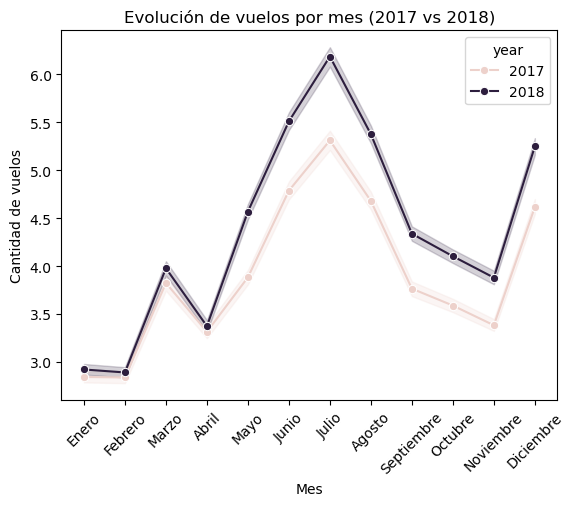

In [500]:
# usar 'lineplot' para ver la distribución y evolución por meses y año
# la librería 'seaborn' maneja variables categóricas (mes) y numéricas (cantidad de vuelos)

sns.lineplot(data=df_completo, x='month', y='flights_booked', hue='year', marker='o')
plt.title('Evolución de vuelos por mes (2017 vs 2018)')
plt.xticks(rotation = 45)
plt.ylabel('Cantidad de vuelos')
plt.xlabel('Mes')
plt.show();

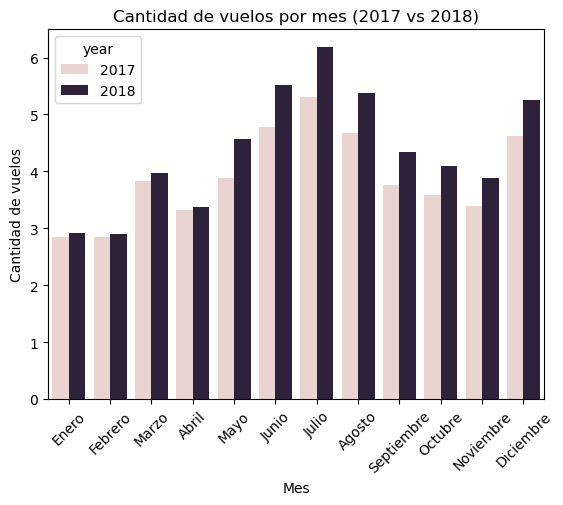

In [501]:
# visualizar usando 'barplot' para ver la distribución por mes, comparando cada año

sns.barplot(data=df_completo, x='month', y='flights_booked', errorbar=None, hue='year')
plt.title('Cantidad de vuelos por mes (2017 vs 2018)')
plt.xticks(rotation=45)
plt.ylabel('Cantidad de vuelos')
plt.xlabel('Mes')
plt.show();

### Conclusiones:

- En 2018 se hicieron mas reservas de vuelos comparado con 2017.

- Julio 2018 es el mes que mas reservas se han realizado comparado con Julio 2017.

- Las reservas de vuelos distribuídas por meses, sigue el mismo patrón para ambos años, siendo Febrero el mes que menos reservas se observan.

---

### 2. ¿Existe una relación entre la distancia de los vuelos y los puntos acumulados por los cliente?

---

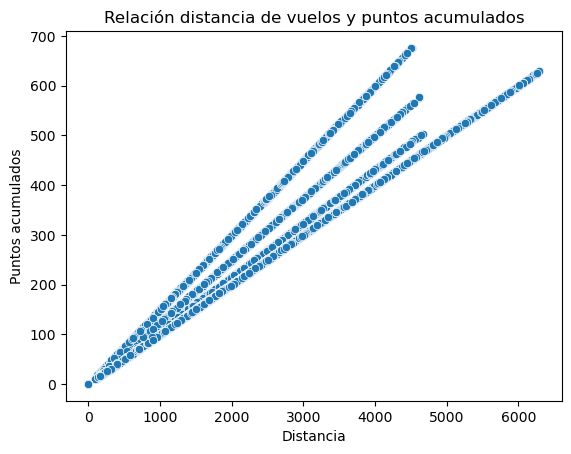

In [534]:
# usar 'scatterplot' para relacionar dos variables numéricas

sns.scatterplot(data=df_completo, x='distance', y='points_accumulated')
plt.title('Relación distancia de vuelos y puntos acumulados')
plt.ylabel('Puntos acumulados')
plt.xlabel('Distancia')
plt.show();

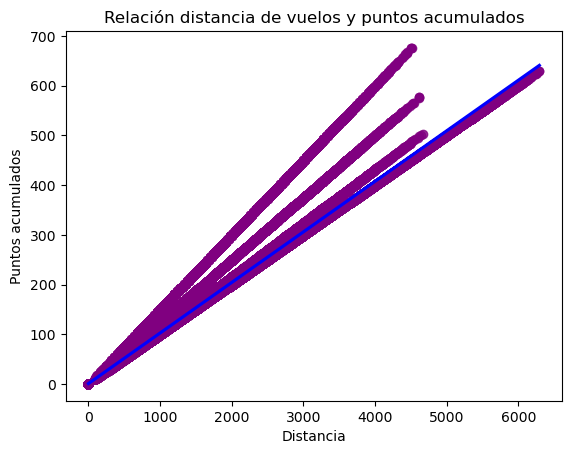

In [535]:
# podemos visualizar la relación de dos variables numéricas usando 'regplot'
# ayuda a ver a la línea de regresión (relación) entre ambas variables

sns.regplot(data=df_completo, x='distance', y='points_accumulated', color='purple', line_kws={"color": "blue"})
plt.title('Relación distancia de vuelos y puntos acumulados')
plt.ylabel('Puntos acumulados')
plt.xlabel('Distancia')
plt.show();

### Conclusiones: 

- Existe una relación lineal y positiva entre la distancia de vuelo y puntos acumulados. Mientras mas distancia de vuelo mas puntos acumulados.

---

### 3. ¿Cuál es la distribución de los clientes por provincia o estado?

---

In [552]:
# visualizar los datos de mayor a menor
# agrupar por provincia y sumar los clientes totales, usando funciones 'groupby()' y 'sum()'

df_agrupado = df_loyalty.groupby('province', as_index=False)['loyalty_number'].sum()

# ordenar de mayor a menor usando la función 'sort_values()' con el parametro 'ascending=False'

df_agrupado = df_agrupado.sort_values('loyalty_number', ascending=False)

In [553]:
# configuración de paleta de colores para la gráfica

custom_palette11 = sns.color_palette('BuPu_r', n_colors=11)

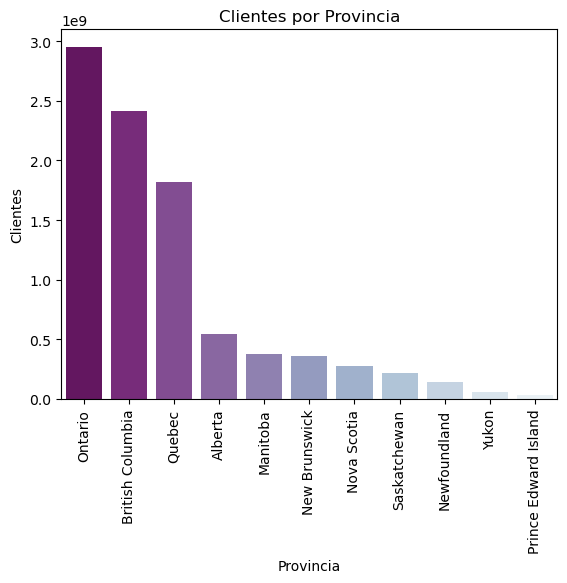

In [554]:
# visualizar usando 'barplot' para ver la distribución de clientes por provincia en un gráfico de barras
# usando el DataFrame previamente trabajado

sns.barplot(data=df_agrupado, x='province', y='loyalty_number', errorbar=None, palette=custom_palette11)
plt.title('Clientes por Provincia')
plt.xticks(rotation=90)
plt.ylabel('Clientes')
plt.xlabel('Provincia')
plt.show();

### Conclusiones:

- La provincia que mas registros se observan es 'Ontario'.

- La provincia que menos clientes tiene es 'Prince Edward Island'.

---

### 4. ¿Cómo se compara el salario promedio entre los diferentes niveles educativos de los clientes?

---

In [555]:
# verificar las columnas del DataFrame a utilizar:

df_loyalty.columns  

Index(['loyalty_number', 'country', 'province', 'city', 'postal_code',
       'gender', 'education', 'salary', 'marital_status', 'loyalty_card',
       'clv', 'enrollment_type', 'enrollment_year', 'enrollment_month',
       'cancellation_year', 'cancellation_month'],
      dtype='object')

In [556]:
# verificar el tipo de datos que tienen las columnas que queremos analizar
# ayuda a decidir que método de visualización necesitamos aplicar

df_loyalty[['salary', 'education']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   salary     16737 non-null  int32 
 1   education  16737 non-null  object
dtypes: int32(1), object(1)
memory usage: 196.3+ KB


In [557]:
# configuración de paleta de colores para la gráfica

custom_palette5 = sns.color_palette('BuPu_r', n_colors=5)

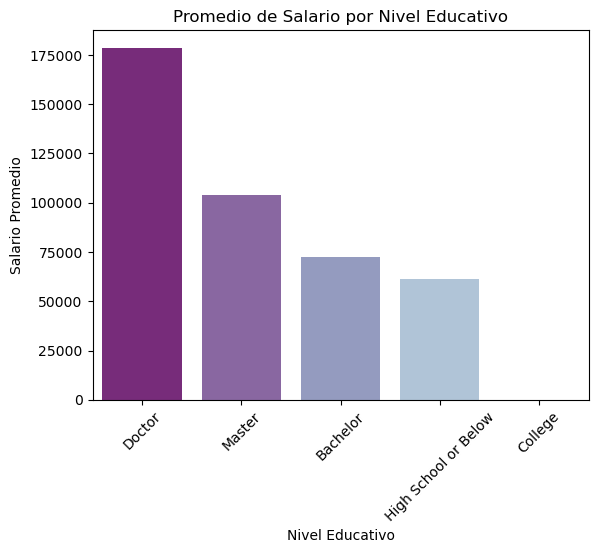

In [568]:
# ordenar de mayor a menor y guardar en una variable
# agrupando los datos por el nivel de educación, usando funciones 'groupby()', 'mean()' para calcular la media y 'sort_values()'

orden_educacion = df_loyalty.groupby('education')['salary'].mean().sort_values(ascending=False).index

# usar 'barplot' para mostrar una gráfica de barras que relaciona una variable numérica (salary) con una categórica (education)
# aplicamos el orden establecido previamente

sns.barplot(data=df_loyalty, x='education', y='salary', order=orden_educacion, errorbar=None, palette=custom_palette5)
plt.xticks(rotation=45)
plt.title('Promedio de Salario por Nivel Educativo')
plt.ylabel('Salario Promedio')
plt.xlabel('Nivel Educativo')
plt.show();

### Conclusiones:

- Los salarios mas altos en promedio pertenecen a la categoria de clientes con Doctorados.

- A los clientes con un nivel de 'Collage' no registran salarios. Sugerir a la empresa revisar los datos de estos clientes con este Nivel Educativo.

- Se detecta que los datos 'nulos' en '0' corresponden al nivel educativo 'Collage'.

---

### 5. ¿Cuál es la proporción de clientes con diferentes tipos de tarjetas de fidelidad?

---

In [560]:
# verificar las columnas del DataFrame a utilizar:

df_loyalty.columns  

Index(['loyalty_number', 'country', 'province', 'city', 'postal_code',
       'gender', 'education', 'salary', 'marital_status', 'loyalty_card',
       'clv', 'enrollment_type', 'enrollment_year', 'enrollment_month',
       'cancellation_year', 'cancellation_month'],
      dtype='object')

In [561]:
# verificar el tipo de datos que tienen las columnas que se quieren analizar
# 'loyalty_number' representa un cliente, que no se repite

df_loyalty[['loyalty_number', 'loyalty_card']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   loyalty_number  16737 non-null  int64 
 1   loyalty_card    16737 non-null  object
dtypes: int64(1), object(1)
memory usage: 261.6+ KB


In [562]:
# verificar la cantidad de 'loyalty_card' que existen en el DataFrame, por cada categoría
# una tarjeta de lealtad representa un cliente

display(df_loyalty['loyalty_card'].value_counts())
print(df_loyalty['loyalty_card'].value_counts().sum()) # total de clientes en el DataFrame

loyalty_card
Star      7637
Nova      5671
Aurora    3429
Name: count, dtype: int64

16737


In [566]:
# configuración de paleta de colores para la gráfica

custom_palette_asc = sns.color_palette('BuPu_r', n_colors=3)

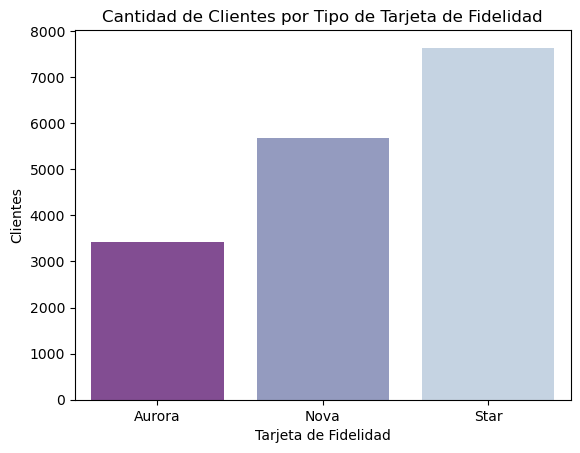

In [569]:
# crear un nuevo DataFrame
# agrupar usando la función 'groupby()' y contar clientes por cada tipo de tarjeta usando función 'count()'

df_tarjetas = df_loyalty.groupby('loyalty_card', as_index=False)['loyalty_number'].count()

# usar 'barplot' para representar una variable numérica 'loyalty_number' con una variable categórica 'loyalty_card'

sns.barplot(data=df_tarjetas, x='loyalty_card', y='loyalty_number', errorbar=None, palette=custom_palette_asc)
plt.title('Cantidad de Clientes por Tipo de Tarjeta de Fidelidad')
plt.ylabel('Clientes')
plt.xlabel('Tarjeta de Fidelidad')
plt.show();

In [ ]:
# configuración de paleta de colores para la gráfica

custom_palette3 = sns.color_palette('BuPu_r', n_colors=3)

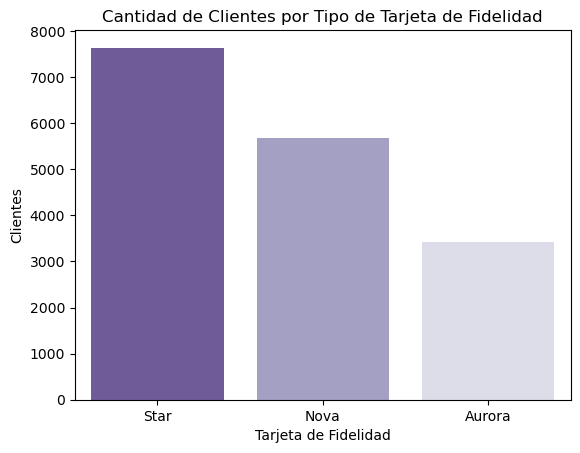

In [571]:
# conociendo que no hay valores duplicados en los id de los clientes (loyalty_number)
# usar 'countplot' para contar la cantidad de veces que se repite el valor de las Tarjetas de fidelidad (loyalty_card) en el DataFrame

sns.countplot(data=df_loyalty, x='loyalty_card', order=df_loyalty['loyalty_card'].value_counts().index, palette=custom_palette3)
plt.title('Cantidad de Clientes por Tipo de Tarjeta de Fidelidad')
plt.ylabel('Clientes')
plt.xlabel('Tarjeta de Fidelidad')
plt.show();

### Conclusiones:

- La categoría de Tarjeta de Lealtad con mas clientes es: 'Star'.

- La categoría de Tarjeta de Lealtad con menos clientes registrados en 'Aurora'.

---

### 6. ¿Cómo se distribuyen los clientes según su estado civil y género?

---

In [572]:
# verificar las columnas del DataFrame que tiene la información que necesitamos

df_loyalty.columns

Index(['loyalty_number', 'country', 'province', 'city', 'postal_code',
       'gender', 'education', 'salary', 'marital_status', 'loyalty_card',
       'clv', 'enrollment_type', 'enrollment_year', 'enrollment_month',
       'cancellation_year', 'cancellation_month'],
      dtype='object')

In [573]:
# verificar el tipo de datos de las columnas que nos interesan, para saber que método de visualización utilizamos

df_loyalty[['loyalty_number', 'gender', 'marital_status']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   loyalty_number  16737 non-null  int64 
 1   gender          16737 non-null  object
 2   marital_status  16737 non-null  object
dtypes: int64(1), object(2)
memory usage: 392.4+ KB


In [575]:
# usar 'barplot': relaciona variables numéricas con categóricas
# agrupar por categorías usando la función 'groupby()' por género y status marital, y la función 'count()' para contar el número de clientes usando 'loyalty_number'
# guardar en un nuevo DataFrame que usaremos para graficar

df_distribucion = df_loyalty.groupby(['gender', 'marital_status'], as_index=False)['loyalty_number'].count()
df_distribucion

,gender,marital_status,loyalty_number
0,Female,Divorced,1269
1,Female,Married,4869
2,Female,Single,2272
3,Male,Divorced,1249
4,Male,Married,4866
5,Male,Single,2212


In [584]:
# configuración de paleta de colores para la gráfica

custom_palette2 = sns.color_palette('BuPu', n_colors=2)

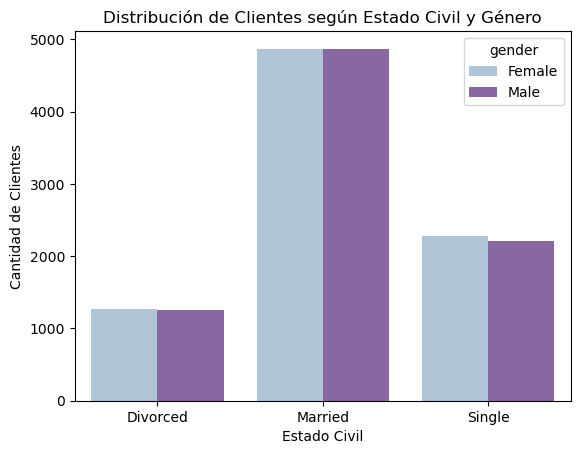

In [585]:
# usar 'barplot' para relacionar 1 variable categoría numérica y 2 variables categóricas

sns.barplot(data=df_distribucion, x='marital_status', y='loyalty_number', hue='gender', errorbar=None, palette=custom_palette2)
plt.title('Distribución de Clientes según Estado Civil y Género')
plt.ylabel('Cantidad de Clientes')
plt.xlabel('Estado Civil')
plt.show();

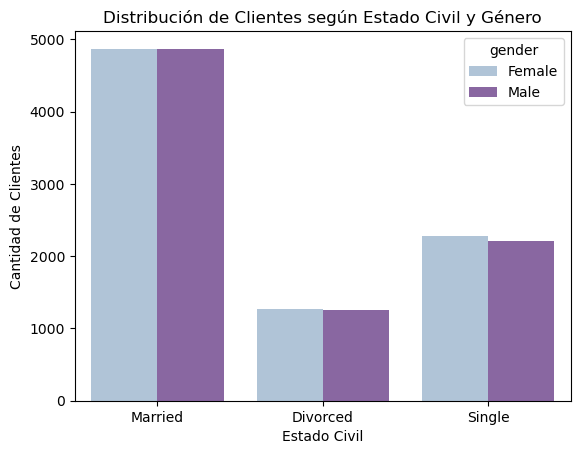

In [583]:
# como cada fila representa un cliente, y al no haber datos duplicados, también se puede visualizar con 'countplot'

sns.countplot(data=df_loyalty, x='marital_status', hue='gender', palette=custom_palette2)
plt.title('Distribución de Clientes según Estado Civil y Género')
plt.xlabel('Estado Civil')
plt.ylabel('Cantidad de Clientes')
plt.show();

### Conclusiones:

- La categoría de Estado Civil que predomina es 'Married'
- La categoría que se registran menos clientes es 'Divorced'
- No hay diferencias entre Estado Civil y Género de los clientes en categorías 'Married' y 'Divorced', 
- Se pueden observar menos mujeres solteras que hombres solteros en esta distribución 


## V. Evaluación de Diferencias en Reservas de Vuelos por Nivel Educativo

Se busca evaluar si existen diferencias significativas en el número de vuelos reservados según el nivel educativo de los clientes

In [ ]:
# 1. Preparación de Datos: Filtra el conjunto de datos para incluir únicamente las columnas relevantes:
# 'Flights Booked' y 'Education'

In [ ]:
df_hipotesis = df_completo[['Flights Booked', 'Education']]
df_hipotesis.head(10)

,Flights Booked,Education
0,0,Bachelor
1,3,Bachelor
2,0,Bachelor
3,0,Bachelor
4,6,Bachelor
5,13,Bachelor
6,12,Bachelor
7,8,Bachelor
8,14,Bachelor
9,2,Bachelor


In [ ]:
# 2. Análisis Descriptivo: Agrupa los datos por nivel educativo y calcula estadísticas descriptivas
# básicas (como el promedio, la desviación estándar) del número de vuelos reservados para cada grupo

In [ ]:
df_grupo = df_hipotesis.groupby(['Education'], as_index=False)['Flights Booked'].count()
df_grupo

,Education,Flights Booked
0,Bachelor,252567
1,College,102260
2,Doctor,17731
3,High School or Below,18915
4,Master,12287


In [ ]:
df_grupo.describe().T

,count,mean,std,min,25%,50%,75%,max
Flights Booked,5.0,80752.0,103036.28672,12287.0,17731.0,18915.0,102260.0,252567.0


In [ ]:
df_completo['Education'].value_counts()

Education
Bachelor                252567
College                 102260
High School or Below     18915
Doctor                   17731
Master                   12287
Name: count, dtype: int64

In [ ]:
bachelor = df_completo[df_completo['Education'] == 'Bachelor']['Flights Booked']
print(bachelor.head())

0    0
1    3
2    0
3    0
4    6
Name: Flights Booked, dtype: int64


In [ ]:
college = df_completo[df_completo['Education'] == 'College']['Flights Booked']
print(college.head())

24     9
25     9
26    14
27     0
28    16
Name: Flights Booked, dtype: int64


In [ ]:
high_School = df_completo[df_completo['Education'] == 'High School or Below']['Flights Booked']
print(high_School.head())

813     9
814    13
815     2
816     9
817     0
Name: Flights Booked, dtype: int64


In [ ]:
doctor = df_completo[df_completo['Education'] == 'Doctor']['Flights Booked']
print(doctor.head())

1341     7
1342     0
1343    15
1344     2
1345    13
Name: Flights Booked, dtype: int64


In [ ]:
master = df_completo[df_completo['Education'] == 'Master']['Flights Booked']
print(master.head())

381     2
382    12
383     0
384    10
385     0
Name: Flights Booked, dtype: int64


In [ ]:
# normalidad: si > 50 elementos kolmogorov-smirnov si < 50 saphiro

print(len(bachelor))
print(len(college))
print(len(high_School))
print(len(doctor))
print(len(master))

252567
102260
18915
17731
12287


In [ ]:
# 3. Prueba Estadística: Realiza una prueba de hipótesis para determinar si existe una diferencia significativa 
# en el número de vuelos reservados entre los diferentes niveles educativos

### Planeto de hipótesis:

- Hipótesis nula (H0): Ambos grupos son iguales, no hay diferencias significativas en el número de vuelos reservados entre los diferentes niveles educativos

- Hipótesis alternativa (H1): Los grupos son significativamente distintos, dentro de los diferentes niveles educativos reservan la misma cantidad de vuelos

In [ ]:
# definir una función para poder hacer el t-test de Student
def prueba_hipotesis(alfa, *args):
    """
    Realiza una prueba de hipótesis para comparar grupos.
    1. Primero verifica si los datos son normales usando el test de Shapiro-Wilk o Kolmogorov-Smirnov.
    2. Si los datos son normales, usa Bartlett para probar igualdad de varianzas. Si no son normales, usa Levene.
    3. Si las varianzas son iguales, usa el t-test de Student; si no, usa la versión de Welch.
    4. Si los datos no son normales, usa el test de Mann-Whitney (alternativa no paramétrica).

    Parámetros:
    *args: listas o arrays con los datos de cada grupo.

    Retorna:
    dict con resultados del test de normalidad, varianza e hipótesis.
    """
    
    # Verificar si hay al menos dos grupos
    if len(args) < 2:
        raise ValueError("Se necesitan al menos dos conjuntos de datos para realizar la prueba.")
    
    # Comprobar normalidad en cada grupo
    normalidad = []
    for grupo in args:
        if len(grupo) > 50:
            p_valor_norm = stats.kstest(grupo, 'norm').pvalue  # Kolmogorov-Smirnov si n > 50
        else:
            p_valor_norm = stats.shapiro(grupo).pvalue  # Shapiro-Wilk si n <= 50
        normalidad.append(p_valor_norm > 0.05)

    datos_normales = all(normalidad)  # True si todos los grupos son normales

    # Prueba de igualdad de varianzas
    if datos_normales:
        p_valor_varianza = stats.bartlett(*args).pvalue  # Test de Bartlett si los datos son normales
    else:
        p_valor_varianza = stats.levene(*args, center="median").pvalue  # Test de Levene si no son normales

    varianzas_iguales = p_valor_varianza > 0.05

    # Aplicar el test adecuado
    if datos_normales:
        if varianzas_iguales:
            p_valor = stats.ttest_ind(*args, equal_var=True).pvalue
            test_usado = "t-test de Student (varianzas iguales)"
        else:
            p_valor = stats.ttest_ind(*args, equal_var=False).pvalue
            test_usado = "t-test de Welch (varianzas desiguales)"
    else:
        try: # si tengo dos grupos
            p_valor = stats.mannwhitneyu(*args).pvalue
            test_usado = "Mann-Whitney U (prueba no paramétrica)"
        except: # si tengo mas de dos grupos
            p_valor = stats.kruskal(*args).pvalue
            test_usado = "Kruskal Wallis"

    # Nivel de significancia
    alfa = alfa

    # Resultados
    resultado = {
        "Test de Normalidad": normalidad,
        "Datos Normales": datos_normales,
        "p-valor Varianza": p_valor_varianza,
        "Varianzas Iguales": varianzas_iguales,
        "Test Usado": test_usado,
        "p-valor": p_valor,
        "Conclusión": "Rechazamos H0 (Diferencias significativas)" if p_valor < alfa else "No se rechaza H0 (No hay diferencias significativas)"
    }

    # Imprimir resultados de manera más clara
    print("\n📊 **Resultados de la Prueba de Hipótesis** 📊")
    print(f"✅ Test de Normalidad: {'Sí' if datos_normales else 'No'}")
    print(f"   - Normalidad por grupo: {normalidad}")
    print(f"✅ Test de Varianza: {'Iguales' if varianzas_iguales else 'Desiguales'} (p = {p_valor_varianza:.4f})")
    print(f"✅ Test aplicado: {test_usado}")
    print(f" p-valor: {p_valor:.4f}")
    print(f"🔍 Conclusión: {resultado['Conclusión']}\n")

    return resultado

In [ ]:
prueba_hipotesis(0.05, bachelor, college, high_School, doctor, master)


📊 **Resultados de la Prueba de Hipótesis** 📊
✅ Test de Normalidad: No
   - Normalidad por grupo: [False, False, False, False, False]
✅ Test de Varianza: Desiguales (p = 0.0150)
✅ Test aplicado: Kruskal Wallis
 p-valor: 0.0015
🔍 Conclusión: Rechazamos H0 (Diferencias significativas)



{'Test de Normalidad': [False, False, False, False, False],
 'Datos Normales': False,
 'p-valor Varianza': 0.014969793534581529,
 'Varianzas Iguales': False,
 'Test Usado': 'Kruskal Wallis',
 'p-valor': 0.0015225470219889367,
 'Conclusión': 'Rechazamos H0 (Diferencias significativas)'}

# Conclusiones:

- Se puede concluir que el nivel educativo de los clientes influyen en la cantidad de vuelos que se reservan